<a href="https://colab.research.google.com/github/EliTaub1/bio108_tutorial/blob/main/cephalopod_distribution_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Species Distributions Models

Among the most fundamental requirements for conserving a species is knowing the locations it inhabits. While obvious, this presents a real obstacle, especially for marine species where collecting systematic observations can be quite difficult.

Species distributions are complex and influenced by a range of factors, both biotic and abiotic.
Species can survive only within certain bounds of environmental variables, which is known as their Hutchinsonian (or fundamental) niche. Though biotic factors and other influences such as anthropogenic development may reduce the actual distribution of a species to a smaller range (the so-called "realized niche"), the Hutchinsonian niche is still valuable as a way to understand the potential for a species to survive within a certain region.

Using this idea of an environmentally-constrained distribution, we can create a Species Distribution Model, which uses the environmental conditions in  locations where a species is known to be present to project where the species will or will not occur.

## Motivating Question: Cephalopod Distribution

Here, we examine the distribution of the squid species *Todaropsis eblanae* in the Canary Current to create a model of where it is distributed. Cephalopods, a class of molluscs which include squid and octopus, have a diverse range of habitats which they inhabit, making them a valuable taxon for understanding the environmental factors underlying their distributions. Considering the diversity of cephalopod life history patterns, it's important to undersand how species are distributed and what role envrionmental variables have in determining their differing distributions.

We are using data from [Luna et al (2025)](https://https://doi.org/10.1111/jbi.15112), which analyzed bathymetric preferences of 90 cephalopod species collected from bottom trawl surveys off the northwest coast of Africa between 2004 and 2012. The data can be found at https://datadryad.org/dataset/doi:10.5061/dryad.15dv41p6j. Luna et al specifically sampled some oceanographic variables where they collected these bottom trawls, but since only depth was made public, we will use a more comprehensive set of oceanographic variables from Bio-ORACLE, a publicly avaiable dataset on worldwide oceanographic variables.

##Tutorial Objectives
In this tutorial, you will learn:
*   Background on Species Distribution Models (SDMs)
*   Implementing a Random Forest SDM in Python
*   Predicting a species' distribution using a SDM
*   Evaluating which environmental variables are most important within a SDM

This tutorial contains two sections. The first focuses on the data processing of species occurrence and Bio-ORACLE data, while the second focuses on data anlaysis, using a dataframe created in the first ("cephalopod_locations") to build and evaluate a species distribution model. Those more interested in the SDM portion of the tutorial are welcome to skip to the data analysis portion.

The data analysis portion features 5 live code segments, where a portion of the code has been eliminated so that students can test their comprehension of what is happening. The answers for these live code segments can be found at the Conclusion section of the tutorial. I recommend that students try to solve these sections on their own, as well as running visualizations of dataframes at the beginning and end of data processing code chunks (using .head(), .info(), .describe(), etc.) so that they understand what data manipulations are taking place.

## Importing and installing packages
First, we install and import necessary packages that we will use in this analysis.

In [2]:
#install packages
! pip install rasterio rioxarray rasterstats pyo_oracle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.9 MB/s eta 0:00:00


In [3]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#geospatial packages
import geopandas as gpd
import rasterio
import rasterio.plot
import xarray as xr
import rioxarray as rio
from shapely.geometry import Point
import rasterstats
#BIO-Oracle data
import pyo_oracle
#Data analysis
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Config file doesn't exist, creating it.
Created configuration at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/config.ini'.


## Data Processing

Before we get into the data analysis, we need to import and format our data. Using the geospatial tools available in Python, we can combine the coordinate data from the cephalopod distribution data with rasterized climate data from BIO-ORACLE.

### Cephalopod Distribution
The data from Luna et al were saved as a Excel (.xlsx) file. For the purposes of this tutorial, they have already been covnerted to a .csv and uploaded to GitHub.

We start by importing the data before turning the Longitude and Latitude values into spatial points that can be read as a GeoDataFrame.

In [4]:
#Import cephalopod data
cephalopod_path = "https://raw.githubusercontent.com/EliTaub1/bio108_tutorial/refs/heads/main/Supporting_data_-_Cephalopods_distribution_paper.csv" #path within google drive, modify as needed
cephalopod = pd.read_csv(cephalopod_path)
cephalopod = cephalopod.dropna()

#create GPD with cephalopod locations as spatial points
cephalopod_coords = cephalopod[["Long L", "Latit L"]]
cephalopod_coords = cephalopod_coords.to_numpy()
cephalopod_locations = [Point(xy) for xy in cephalopod_coords] #converts coordinate array into spatial points

cephalopod_locations = gpd.GeoDataFrame(cephalopod_locations,
                                  columns=['geometry'],
                                  crs="epsg:4326")
#add family and species data for each data point to our GeoDataFrame
cephalopod_locations["Species"] = cephalopod["Species"]

#remove NA locations
cephalopod_locations = cephalopod_locations.loc[(cephalopod_locations.is_empty) == False]

### Envrionmental Variables
Now, we add in our oceanographic data from Bio-ORACLE (https://bio-oracle.org/index.php). Bio-ORACLE has an associated package, pyo_oracle, which makes it easy to acquire Bio-ORACLE datasets and download them directly into our directory!

First, we filter layers to get only the ones we desire and then we download these layers in the temporal and geographical range used in the reference study.

In [5]:
# Get full list of layers available
bio_oracle_layers = pyo_oracle.list_layers()

#reset pyo_oracle data from previous uses and then recreate folder
os.system('rm -rf /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')
os.system('mkdir /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')

#Select only layers of variables taken during the baseline period (2000-2018/2019/2020)
baselineLayers = bio_oracle_layers[bio_oracle_layers["datasetID"].str.contains("baseline")]
#Select only layers of variables taken at the benthic layer (as this is where the bottom trawls were conducted)
usedLayers = baselineLayers[baselineLayers["datasetID"].str.contains("depthmean")]

# Define constraints on layers to be in desired temporal range and latitude/longitude range. Here, we use the constraints of our reference study.y
constraints = {
    "time>=": "2004-01-01T00:00:00Z",
    "time<=": "2012-01-01T12:00:00Z",
    "time_step": 1,
    "latitude>=": 8,
    "latitude<=": 36,
    "latitude_step": 1,
    "longitude>=": -20,
    "longitude<=": 11,
    "longitude_step": 1
}

#Download layers using the IDs remaining after we've filtered
for title in usedLayers.datasetID:
  pyo_oracle.download_layers(title, constraints=constraints, skip_confirmation = True)

Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/chl_baseline_2000_2018_depthmean_2025-04-21-215004.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/dfe_baseline_2000_2018_depthmean_2025-04-21-215009.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/

However, we still have one more major step we need to do. Because our data is given in netcdf file format, many of our geospatial packages (e.g. rasterio) cannot effectively work with them. Thus, we convert our files to geoTIFF format in order to make them accessible.

In [6]:
#Reference: https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff
#Create save location for files
save_folder = '/content/oceandata/'
os.system(('mkdir /content/oceandata/'))

#List all files in the directory with .nc suffix
pyo_directory = "/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/"
nc_filenames = os.listdir(pyo_directory)
nc_filenames = [s for s in nc_filenames if ".nc" in s]

#Rewrite nc as a .tif as save
for filename in nc_filenames:
  #open file with name suffix
  variable_path = pyo_directory + filename
  variable = xr.open_dataset(variable_path)
  #only extract the data variable with "mean" in the name
  var_name = [s for s in variable._variables if "mean" in s]
  var_data = variable[var_name[0]]
  #convert var_data into a format where it can be saved as .tif
  var_data = var_data.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
  var_data = var_data.rio.write_crs("epsg:4326", inplace=True)
  #save var_data
  save_loc = save_folder + var_name[0] + ".tif"
  var_data.rio.to_raster(save_loc)

### Combining Data Sources

Now, we extract envriomental data for each of the datapoints and add it back to the cephalopod location GeoDataFrame, creating a combined data frame with survey locations and the environmental parameters there.

In [7]:
#find list of filenames of our saved .tif files
tif_filenames = os.listdir(save_folder)

for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))

  #extract envrionmental variable data
  variable_results = rasterstats.point_query(
      cephalopod_locations,
      variable_raster.read(1),
      nodata = variable_raster.nodata,
      affine = variable_raster.transform,
      interpolate='nearest'
  )
  #add envrionmental variable data back to cephalopod data
  cephalopod_locations[filename.replace(".tif",'')] = variable_results

#remove NA values
cephalopod_locations = cephalopod_locations.dropna()

##Data Analysis

Now, we construct a basic model to predict the distribution of *Todaropsis eblanae*.

This seems like an immensely complex task, since we sampled only a small range of locations in the Canary Current and yet we are looking to make a prediction for any point within the area. How can we do that?

Luckily, this is where machine learning can be quite valuable! Machine learning methods are designed for using training data and extrapolating it to make predictions for data that has not yet been seen. Using a Random Forest model, we can get a sense of where our species will and won't be present.

###Building Our Training Data
For our first step, we need to format our data in a way that our model can understand.

Our model is going to be using environmental conditions to predict *Todaropsis eblanae* distribution, meaning that we need to have data on both locations where *Todaropsis eblanae* is present and ones where it was not found. Most studies that create SDMs do not have these sorts of information and must instead use **pseudo-absences**, where artifical absences are selected across the geographic range being studied. Fortunately, because our dataset is from a collection of cephalopod surveys, we have specific locations where *Todaropsis eblanae* were not found that we can use as real absences for our model.

To begin with, we need to make sure each location is counted as a single data point, so that no location gets extra emphasis in our model because multiple cephalopods were found there. We do this while marking each location as one where *Todaropsis eblanae* either was or was not found in our surveys.

First, we get each location where *Todaropsis eblanae* was found and eliminate duplicates so that each location is used only once.

In [ ]:
#Create locations where study species was found
tod_ebl_locations = cephalopod_locations[cephalopod_locations["Species"] == "Todaropsis eblanae"]
tod_ebl_locations = tod_ebl_locations.drop_duplicates(subset = ###LIVE CODE 1###) #remove duplicate locations (i.e. ones that share geometry)
tod_ebl_locations["tod_ebl"] = True #input variable for recording tod_ebl presence

Next, we create a dataframe of locations with geometry different than the locations where *Todaropsis eblanae* was found (i.e. places where surveys occurred but *Todaropsis eblanae* was absent).

In [ ]:
#Create locations where study species was not found
other_locations = cephalopod_locations[###LIVE CODE 2###] #select only locations where tod_ebl was not found (i.e. geometry does not match tod_ebl_locations)
other_locations = other_locations.drop_duplicates(subset = "geometry") #remove duplicate locations
other_locations["tod_ebl"] = False #input variable for recording tod_ebl absence

We combine these presence and absence locations into a single dataframe to use as our model input.

In [ ]:
#Combine dataframes into single entry
frame_concat = [tod_ebl_locations, other_locations]
location_frame = pd.concat(frame_concat)

Now, we need to create a set of training data of our explanatory variables and response variable, as well as a test dataset for evaluating our model (which can't be used in training as we are testing the ability of our model to extrapolate).
For our model, we are hoping to use environment to predict *Todaropsis eblanae* presence/absence, so we will use the former as our data and the latter as our target.

In [ ]:
#Create training and test data
location_data = location_frame.drop(["geometry", "Species","tod_ebl"], axis = 1) #data: environmental variables
location_target = ###LIVE CODE 3### #target: tod_ebl occurrence
#Randomly divide data into training and test sets
traindata, testdata, traintarget, testtarget = train_test_split(location_data, location_target, random_state = 47)

### Model Creation and Validation

Let's use the Random Forest Classifier model in SciKit Learn to create our model for the SDM. While the details of how the Random Forest Classifier works is outside the scope of this tutorial, it is a versitile model for using predictive quantitative variables to infer which classification a data point will fit into, making it a perfect fit for using environmental data to classify a species as present or absent.

In [ ]:
#Feed data into RandomForestClassifier
model = RandomForestClassifier(n_estimators=5000, random_state=47)
model.fit(traindata, traintarget)

RandomForestClassifier(n_estimators=5000, random_state=47)

We're not out of the woods just yet! First, we need to validate our model and see how accurate it is. Using our test data set, we have our model predict where *Todaropsis eblanae* is or is not present.

              precision    recall  f1-score   support

       False       0.87      0.95      0.91       209
        True       0.52      0.28      0.36        40

    accuracy                           0.84       249
   macro avg       0.70      0.61      0.64       249
weighted avg       0.82      0.84      0.82       249



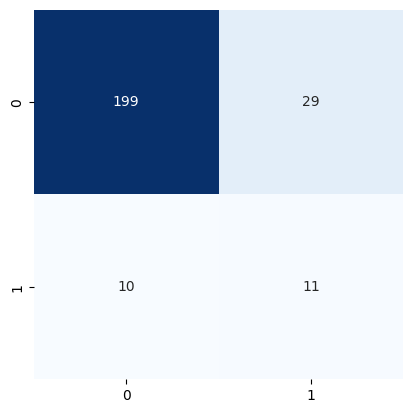

In [ ]:
#Generate and test predictions
pred = model.predict(testdata)

#Create and plot confusion matrix
mat = confusion_matrix(###LIVE CODE 4###) #see where target data and predictions match

sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
#Print classifircation report of data
print(metrics.classification_report(testtarget, pred))

We've run into a major problem! This model is built around predictive accuracy, so because we had so many more absences than presences in our training model,  there's less penalty for being wrong about the less common category. Our model is thus quite conservative and barely classifies any areas as those where our target species will be present. This means that the model had a recall for presences of only 28%, meaning that just 28% of real presences were selected by the model as locations where *Todaropsis eblanae* might be present.

We can correct this by instead using a Balanced Random Forest Classifier. This model uses a technique called bootstrapping to, for every training run, select a random subset of the more common classifier data type, creating a balanced sample of presences and absences. In essence, this model will prioritize being correct for each category equally and thus will be more willing to select a location as a presence.

In [ ]:
#Feed data into BalancedRandomForestClassifier
balanced_model = BalancedRandomForestClassifier(n_estimators=5000, random_state=47)
balanced_model.fit(traindata, traintarget)

BalancedRandomForestClassifier(n_estimators=5000, random_state=47)

Let's validate this new model!

              precision    recall  f1-score   support

       False       0.91      0.72      0.81       209
        True       0.30      0.62      0.41        40

    accuracy                           0.71       249
   macro avg       0.61      0.67      0.61       249
weighted avg       0.81      0.71      0.74       249



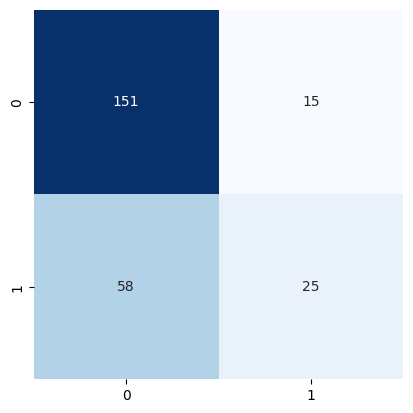

In [ ]:
#Generate and test predictions
pred = balanced_model.predict(testdata)

#Create and plot confusion matrix
balanced_mat = confusion_matrix(testtarget, pred) #see where target data and predictions match

sns.heatmap(balanced_mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
#Print classifircation report of data
print(metrics.classification_report(testtarget, pred))

While our recall is much improved to 62%, our new model is still very flawed! Our new model had a precision for presences of only 30%, meaning that predicted presences only had a 30% chance of actually being present.

We can begin to see some of the tradeoffs that are present in Species Distribution Modelling. It's difficult to get more data, and even if perhaps the underlying model can be improved, there's a limit to predictive capacity. How do we decide what model is best for our purposes?

Let's consider our data being used here. We are certain that all locations marked as present contain *Todaropsis eblanae*, but even though our absences are better than pseudo-absences, we still can't be certain *Todaropsis eblanae* is not in the area (just that we Luna et al find any in the bottom trawl). Thus, it seems more likely that our data contains false negatives than false positives, so we will select the model with better recall for future analyses.

### Predicting *Todaropsis eblanae* Distribution

Now that we've created this model, we make predictions on *Todaropsis eblanae* presence/absence for all points within the study area.

To do this, we need to start by formatting our environmental data in a way that the model can process, converting it from a raster to a dataframe. Note that our data is coming from 12 rasters that are formatted as 561 x 621 arrays, and we convert it into a dataframe where each cell has its own row, meaning that we are creating a 12 x (561*621 = 348381) dataframe.

In [ ]:
#access filenames of environmental variables
tif_filenames = os.listdir(save_folder)

#create a placeholder array of zeroes to hold the data from the environmental variables
holderArray = np.zeros((12, 561, 621))
i = 0

#create array with all data from the environmental variables
for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))
  #add data from raster to the holderArray
  holderArray[[i]] = variable_raster.read(1)
  i = i + 1

#reformat the data to have 348381 (561*621) rows with each of the 12 envrionmental variables, so it can be fed into our model
newHolder = pd.DataFrame(holderArray.reshape(12, 348381).transpose(1,0))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(


Using the predict feature in our Balanced Random Forest Classifier, we can generate predictions for each of the 348381 locations.

In [ ]:
#use our random forest model on the new data
holderpred = balanced_model.predict(newHolder)

#reformat the new data to be plottable by reshaping to be a grid and coercing to be a integer
holderpred = holderpred.reshape(###LIVE CODE 5###).astype(int) #reshape to the original raster dimensions, change data type to int
#convert holderpred values corresponding to no data (land areas) to be null
holderpred[holderArray[1] == -9999.9] = None

NameError: name 'pd' is not defined

Now, let's plot our SDM!

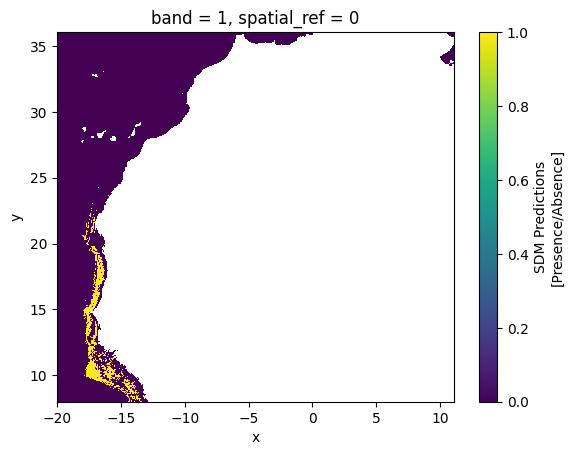

In [ ]:
# Convert the predictions (holderpred) to a DataArray, matching the spatial structure of the original raster
predictions_xr = rio.open_rasterio(save_folder + tif_filenames[0]).copy(deep=True)
predictions_xr.values[0] = holderpred
predictions_xr.attrs["ioos_category"] = "Presence/Absence"
predictions_xr.attrs["long_name"] = "SDM Predictions"
predictions_xr.attrs["units"] = "Presence/Absence"

predictions_xr[0].plot()

We can now see a predicted distribution of *Todaropsis eblanae* (the areas in yellow)! Even in areas where we have not surveyed, our model predicts habitat suitability or lack thereof, which is quite critical considering that it would take immense effort to survey in every 0.05 degree of latitude and longitude on the map.

### Evaluating Environmental Variable Importance

But which variables have the greatest importance in limiting *Todaropsis eblanae* distribution? Using the feature_importances feature for our Balanced Random Forest Classifier, we can find out which make the greatest contrabutions to how the classifier makes its decisions.

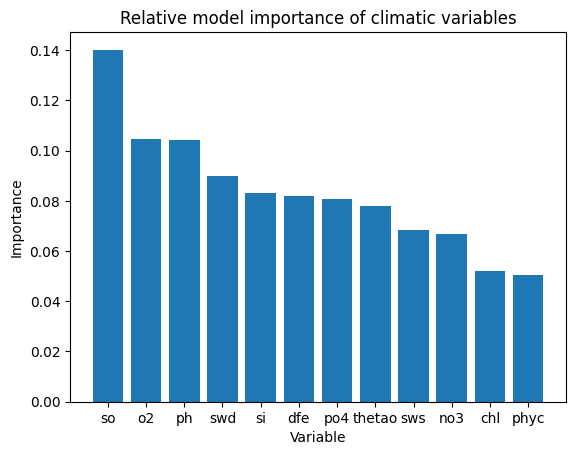

In [ ]:
#find importance values
importance = balanced_model.feature_importances_

#determine corresponding labels
labels = np.array(location_data.columns)
#format labels so that they no longer include mean!
for i in range(12): labels[i] = labels[i].split("_")[0]
#convert to series with labels
labeled_importance = pd.Series(importance, labels)
#sort values from greatest to least
labeled_importance = labeled_importance.sort_values(ascending = False)

Lastly, let's plot these importances!

In [ ]:
#plot labeled importance
fig, ax = plt.subplots()

#use bar plot
ax.bar(labeled_importance.index, labeled_importance)

#Set plot labels
ax.set_ylabel('Importance')
ax.set_xlabel('Variable')
ax.set_title('Relative model importance of climatic variables')

plt.show()

The three most important variables are salinity (so), dissolved oxygen (o2), and pH.

However, it is worth noting this could be in part due to spatial autocorrelation, as Luna et al noted that salinity and dissolved oxygen had significant relationships with latitude in the Canary Current and thus this observed relationship may be driven by some confounding variable associated with latitude of location rather than salinity and oxygen themselves.

## Conclusions

In this tutorial, we've explored the use of Python to build Species Distribution Models.

Using this technique, we were able to predict the distribution of a marine species and explore which environmental variables were most important in determining its distribution. This contributes valuable information for understanding its ecology, making conservation efforts possible for this species.

Through participating in this tutorial, you have now gained the skills to create, implement, and evaluate a Random Forest SDM of your own in Python.

*Live Code Solutions:*
```
1. "geometry"
2. ~ cephalopod_locations["geometry"].isin(tod_ebl_locations.geometry)
3. location_frame.tod_ebl
4. testtarget, pred
5. 561, 621
```